# Deep Q-Network (DQN) on CartPole v1  

---

In this notebook, I am going to implement **Deep Q-Network (DQN)** on the [CartPole v1 environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) using the **PyTorch** framework.  

I will:  

1. **Understand the Problem**:
   - Explore the CartPole v1 environment provided by OpenAI Gym.
   - Understand the state-space, action-space, and the reward structure of the environment.

2. **Implement the DQN Algorithm**:
   - Define the neural network architecture to approximate the Q-value function.
   - Implement the experience replay buffer to store and sample transitions.
   - Use the ε-greedy policy for balancing exploration and exploitation.
   - Implement the target network to stabilize training.

3. **Train the Agent**:
   - Define the training loop where the agent interacts with the environment.
   - Update the Q-network based on the Bellman equation.
   - Periodically update the target network.

4. **Evaluate Performance**:
   - Track and visualize the agent's performance during training.
   - Analyze the rewards and stability of the learned policy.

In [1]:
!pip install gym

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import time

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        
        x = self.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = 0.95          
        self.epsilon = 1.0         
        self.epsilon_min = 0.01    
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 
        self.batch_size = 64       

        self.memory = deque(maxlen=2000)  

        self.policy_net = DQN(input_size=self.state_size, output_size=self.action_size).to(self.device)
        self.target_net = DQN(input_size=self.state_size, output_size=self.action_size).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, evaluate=False):
        if not evaluate and np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device) 
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values, dim=1).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return  

        minibatch = random.sample(self.memory, self.batch_size)

        states = torch.FloatTensor([experience[0] for experience in minibatch]).to(self.device)
        actions = torch.LongTensor([experience[1] for experience in minibatch]).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor([experience[2] for experience in minibatch]).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor([experience[3] for experience in minibatch]).to(self.device)
        dones = torch.FloatTensor([float(experience[4]) for experience in minibatch]).unsqueeze(1).to(self.device)

        with torch.no_grad():
            target_q = self.target_net(next_states).max(dim=1, keepdim=True)[0]
            target_q = rewards + (self.gamma * target_q * (1 - dones))

        current_q = self.policy_net(states).gather(1, actions)
        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [ ]:
def train_cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size=state_size, action_size=action_size)

    episodes = 500
    target_update_frequency = 10
    scores = []
    solved_score = 195
    for episode in range(episodes):
        state = env.reset()
        score = 0
        done = False

        while not done:
            action = agent.act(state)

            next_state, reward, done, _ = env.step(action)


            agent.remember(state, action, reward, next_state, done)

            agent.replay()

            state = next_state
            score += reward

        if (episode + 1) % target_update_frequency == 0:
            agent.update_target_network()

        scores.append(score)
        mean_score = np.mean(scores[-100:])

        print(f"Episode: {episode + 1}, Score: {score}, Average Score: {mean_score:.2f}, Epsilon: {agent.epsilon:.2f}")

        if mean_score >= solved_score and episode >= 100:
            print(f"\nEnvironment solved in {episode + 1} episodes! Average Score: {mean_score:.2f}")
            break

    env.close()
    return agent, scores

In [9]:
def train_cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size=state_size, action_size=action_size)

    episodes = 500
    target_update_frequency = 10
    scores = []
    solved_score = 195  

    for episode in range(episodes):
        reset_output = env.reset()
        if isinstance(reset_output, tuple):
            state, info = reset_output
        else:
            state = reset_output
            info = {}

        score = 0
        done = False

        while not done:
            action = agent.act(state)

            step_output = env.step(action)
            if len(step_output) == 5:
                next_state, reward, done, truncated, info = step_output
                if truncated:
                    done = True
            elif len(step_output) == 4:
                next_state, reward, done, info = step_output
            else:
                raise ValueError(f"Unexpected number of return values from env.step(): {len(step_output)}")


            agent.remember(state, action, reward, next_state, done)

            agent.replay()

            state = next_state
            score += reward

        if (episode + 1) % target_update_frequency == 0:
            agent.update_target_network()

        scores.append(score)
        mean_score = np.mean(scores[-100:])

        print(f"Episode: {episode + 1}, Score: {score}, Average Score: {mean_score:.2f}, Epsilon: {agent.epsilon:.2f}")

        if mean_score >= solved_score and episode >= 100:
            print(f"\nEnvironment solved in {episode + 1} episodes! Average Score: {mean_score:.2f}")
            break

    env.close()
    return agent, scores

Training the agent...
Episode: 1, Score: 11.0, Average Score: 11.00, Epsilon: 1.00
Episode: 2, Score: 15.0, Average Score: 13.00, Epsilon: 1.00
Episode: 3, Score: 19.0, Average Score: 15.00, Epsilon: 1.00


C:\Users\arenf\AppData\Local\Temp\ipykernel_7968\734910085.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.FloatTensor([experience[0] for experience in minibatch]).to(self.device)


Episode: 4, Score: 25.0, Average Score: 17.50, Epsilon: 0.97
Episode: 5, Score: 21.0, Average Score: 18.20, Epsilon: 0.87
Episode: 6, Score: 28.0, Average Score: 19.83, Epsilon: 0.76
Episode: 7, Score: 11.0, Average Score: 18.57, Epsilon: 0.71
Episode: 8, Score: 15.0, Average Score: 18.12, Epsilon: 0.66
Episode: 9, Score: 28.0, Average Score: 19.22, Epsilon: 0.58
Episode: 10, Score: 36.0, Average Score: 20.90, Epsilon: 0.48
Episode: 11, Score: 21.0, Average Score: 20.91, Epsilon: 0.43
Episode: 12, Score: 13.0, Average Score: 20.25, Epsilon: 0.41
Episode: 13, Score: 13.0, Average Score: 19.69, Epsilon: 0.38
Episode: 14, Score: 22.0, Average Score: 19.86, Epsilon: 0.34
Episode: 15, Score: 14.0, Average Score: 19.47, Epsilon: 0.32
Episode: 16, Score: 23.0, Average Score: 19.69, Epsilon: 0.28
Episode: 17, Score: 15.0, Average Score: 19.41, Epsilon: 0.26
Episode: 18, Score: 12.0, Average Score: 19.00, Epsilon: 0.25
Episode: 19, Score: 21.0, Average Score: 19.11, Epsilon: 0.22
Episode: 20, S

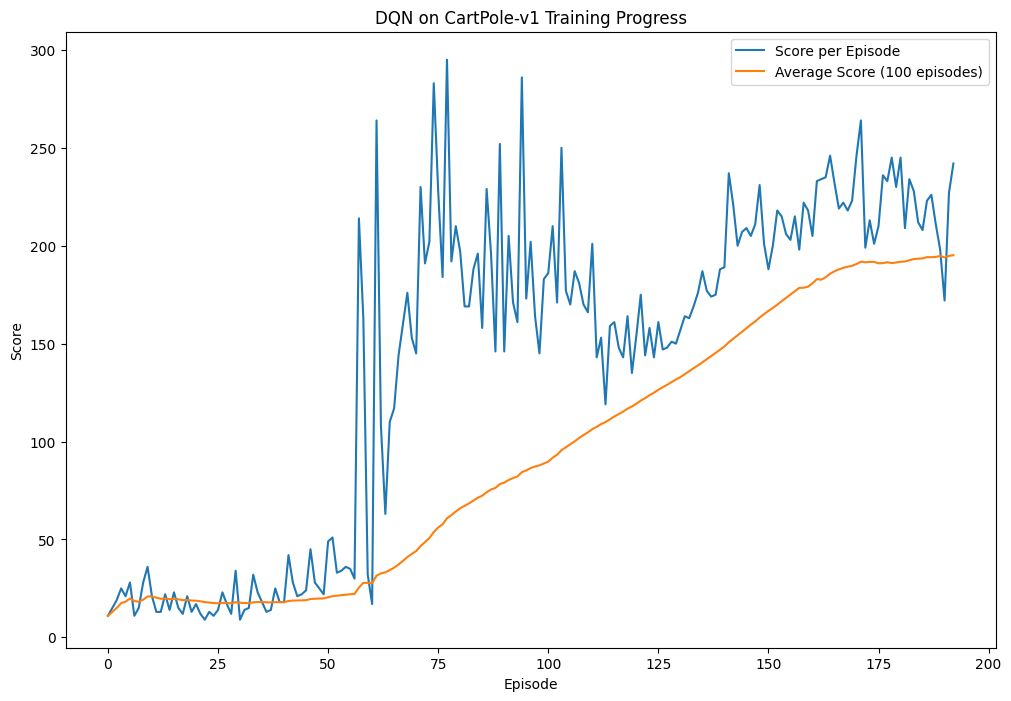


Starting visualization...


C:\Users\arenf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Visualization Episode 1: Score = 275.0
Visualization Episode 2: Score = 256.0
Visualization Episode 3: Score = 233.0
Visualization Episode 4: Score = 228.0
Visualization Episode 5: Score = 219.0


In [ ]:
print("Training the agent...")
agent, scores = train_cartpole()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(scores, label='Score per Episode')
moving_avg = [np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]
plt.plot(moving_avg, label='Average Score (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DQN on CartPole-v1 Training Progress')
plt.legend()
plt.show()

print("\nStarting visualization...")
visualize_agent(agent)